In [11]:
%pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\python.exe -m pip install --upgrade pip' command.


In [12]:
from src.utils import astype_to_category, convert_category_into_integer
from src.model.decision_tree import decision_tree
from src.model.logistic_regression import logit
from src.model.svm import svc

import pandas as pd
import numpy as np
import random
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.datasets as ds
import torchvision.transforms as transforms

import lightning as L
from lightning.pytorch.trainer import Trainer
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingClassifier
from sklearn.svm import SVC

import warnings

In [13]:
## 경고 무시
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
## train, test 데이터 불러오기
origin_train = pd.read_csv('../data/train.csv', encoding='cp949')
display(origin_train)
display(origin_train.ActiveSubs.value_counts())

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,UnansweredCalls,CustomerCareCalls,ThreewayCalls,ReceivedCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallForwardingCalls,CallWaitingCalls,MonthsInService,UniqueSubs,ActiveSubs,ServiceArea,Handsets,HandsetModels,CurrentEquipmentDays,AgeHH1,AgeHH2,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,Homeownership,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,NonUSTravel,OwnsComputer,HasCreditCard,RetentionCalls,RetentionOffersAccepted,NewCellphoneUser,NotNewCellphoneUser,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,3000002,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,0.7,0.7,6.3,0.0,0.0,97.2,0.0,0.0,58.0,24.0,1.3,0.0,0.3,61,2,1,SEAPOR503,2.0,2.0,361.0,62.0,0.0,No,No,Yes,No,No,Known,Yes,Yes,No,No,Yes,Yes,1,0,No,No,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No
1,3000010,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,0.3,0.0,2.7,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.3,0.0,0.0,58,1,1,PITHOM412,2.0,1.0,1504.0,40.0,42.0,Yes,No,No,No,No,Known,Yes,Yes,No,No,Yes,Yes,0,0,Yes,No,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes
2,3000014,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.3,0.0,1.3,3.7,0.0,0.0,0.0,60,1,1,MILMIL414,1.0,1.0,1812.0,26.0,26.0,Yes,No,No,No,No,Unknown,No,No,No,No,No,Yes,0,0,Yes,No,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes
3,3000022,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,52.0,7.7,76.0,4.3,1.3,200.3,370.3,147.0,555.7,303.7,59.7,0.0,22.7,59,2,2,PITHOM412,9.0,4.0,458.0,30.0,0.0,No,No,Yes,No,No,Known,Yes,Yes,No,No,No,Yes,0,0,Yes,No,0,6,No,0,10,No,4-Medium,Other,Other,No
4,3000026,Yes,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53,2,2,OKCTUL918,4.0,3.0,852.0,46.0,54.0,No,No,No,No,No,Known,Yes,Yes,No,No,Yes,Yes,0,0,No,Yes,0,9,No,1,10,No,1-Highest,Other,Professional,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51042,3399958,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.3,2.7,48.3,0.0,0.0,58.9,17.0,1.3,160.3,33.3,12.0,0.0,0.3,29,1,1,LAXSFN818,2.0,2.0,526.0,68.0,64.0,No,Yes,Yes,No,No,Known,Yes,Yes,No,No,No,Yes,0,0,No,No,0,6,No,0,60,No,1-Highest,Suburban,Other,Yes
51043,3399974,No,95.17,1745.0,85.0,0.99,45.0,4.7,122.0,15.9,16.7,0.7,41.3,0.0,0.0,681.5,89.7,33.3,318.7,248.3,17.3,0.0,14.3,29,1,1,LAXCDG310,2.0,2.0,464.0,48.0,48.0,Yes,No,Yes,No,No,Known,Yes,Yes,No,No,Yes,Yes,0,0,No,No,0,9,No,1,60,No,3-Good,Other,Other,No
51044,3399978,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.7,4.3,287.0,1.3,13.7,1225.3,430.3,87.7,1359.0,910.3,76.0,0.0,6.7,25,1,1,LAXCDG310,3.0,2.0,378.0,36.0,0.0,No,No,Yes,No,No,Known,No,No,No,No,No,Yes,0,0,No,No,0,7,No,1,80,No,5-Low,Other,Clerical,No
51045,3399990,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31,1,1,NEVPOW619,2.0,2.0,433.0,32.0,0.0,Yes,No,Yes,No,No,Unknown,No,No,No,No,No,No,0,0,No,No,0,9,No,0,30,No,5-Low,Other,Other,No


ActiveSubs
1     36267
2     12223
3      1907
4       444
5       144
0        39
6        13
8         5
7         2
9         1
53        1
11        1
Name: count, dtype: int64

In [14]:
origin_test = pd.read_csv('../data/test.csv', encoding='cp949')
origin_test

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,UnansweredCalls,CustomerCareCalls,ThreewayCalls,ReceivedCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallForwardingCalls,CallWaitingCalls,MonthsInService,UniqueSubs,ActiveSubs,ServiceArea,Handsets,HandsetModels,CurrentEquipmentDays,AgeHH1,AgeHH2,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,Homeownership,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,NonUSTravel,OwnsComputer,HasCreditCard,RetentionCalls,RetentionOffersAccepted,NewCellphoneUser,NotNewCellphoneUser,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,3000006,NaN,57.49,483.0,37.0,0.25,23.0,0.0,532.0,51.0,8.3,1.0,61.3,1.7,0.3,55.3,46.3,6.3,83.7,157.0,9.3,0.0,5.7,56,1,1,MILMIL414,7,6,240,30.0,0.0,No,No,Yes,Yes,Yes,Unknown,Yes,Yes,No,No,No,Yes,0,0,No,Yes,0,5,No,1,150,No,5-Low,Other,Other,No
1,3000018,NaN,55.23,570.0,72.0,0.00,0.0,0.0,38.0,0.0,9.7,0.7,77.0,8.7,0.0,106.3,14.7,0.7,97.3,90.3,10.3,0.0,0.0,57,1,1,NNYSYR315,6,4,434,56.0,0.0,No,No,Yes,No,No,Known,No,No,No,No,Yes,Yes,0,0,Yes,No,0,6,No,2,80,No,1-Highest,Other,Professional,No
2,3000034,NaN,97.34,1039.0,50.0,4.95,420.0,0.0,198.0,23.3,12.7,3.0,176.0,11.3,0.3,213.9,103.3,0.3,238.3,192.3,15.7,0.0,4.0,55,1,1,MILMIL414,3,3,700,38.0,24.0,No,No,No,No,No,Unknown,No,No,No,No,No,No,0,0,Yes,No,0,4,No,3,10,No,3-Good,Suburban,Crafts,Yes
3,3000070,NaN,35.59,153.0,30.0,0.00,16.0,0.0,30.0,7.3,2.0,0.7,17.3,0.0,0.0,33.1,8.0,4.7,48.3,7.0,2.7,0.0,0.3,59,3,2,SLCSLC801,6,5,48,46.0,0.0,Yes,No,Yes,Yes,Yes,Known,Yes,Yes,Yes,No,No,Yes,0,0,No,Yes,0,4,No,1,200,No,1-Highest,Other,Other,No
4,3000074,NaN,55.27,1213.0,50.0,0.74,0.0,1.3,169.0,1.0,2.7,6.0,43.7,4.3,0.0,490.1,50.7,8.3,189.3,105.0,8.7,0.0,4.3,52,1,1,OKCTUL918,4,4,408,58.0,0.0,No,No,Yes,No,No,Known,Yes,Yes,No,No,No,Yes,0,0,No,Yes,0,3,No,0,10,No,1-Highest,Suburban,Other,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,3399938,NaN,85.15,815.0,88.0,0.00,1.0,0.4,0.0,0.0,12.0,0.0,15.3,0.0,1.3,141.0,9.0,3.3,72.0,38.7,12.0,0.0,0.0,27,3,2,LAXVNY818,3,3,230,64.0,64.0,No,No,Yes,No,No,Unknown,No,No,No,No,No,Yes,0,0,No,No,0,0,No,0,40,No,1-Highest,Other,Other,Unknown
19996,3399950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,1.7,0.0,0.0,0.0,25,1,1,LAXRIV909,1,1,773,34.0,26.0,No,No,Yes,No,No,Known,No,No,No,No,Yes,Yes,0,0,No,No,0,6,No,0,Unknown,No,1-Highest,Suburban,Other,Yes
19997,3399966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.3,0.7,0.3,5.3,3.3,0.0,0.0,0.0,25,1,1,LAXCOR909,1,1,773,0.0,0.0,No,No,Yes,No,No,Unknown,No,No,No,No,No,Yes,0,0,Yes,No,0,8,No,1,Unknown,No,1-Highest,Suburban,Other,No
19998,3399970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,3.3,26.7,4.3,0.0,235.4,35.0,3.3,146.3,115.3,22.3,0.0,6.3,25,1,1,LAXLAG949,3,2,32,28.0,48.0,No,No,Yes,No,No,Unknown,No,No,No,No,No,Yes,0,0,No,No,0,3,No,0,150,No,3-Good,Other,Other,Unknown


In [15]:
origin_test.isna().sum()

CustomerID                       0
Churn                        20000
MonthlyRevenue                  60
MonthlyMinutes                  60
TotalRecurringCharge            60
DirectorAssistedCalls           60
OverageMinutes                  60
RoamingCalls                    60
PercChangeMinutes              135
PercChangeRevenues             135
DroppedCalls                     0
BlockedCalls                     0
UnansweredCalls                  0
CustomerCareCalls                0
ThreewayCalls                    0
ReceivedCalls                    0
OutboundCalls                    0
InboundCalls                     0
PeakCallsInOut                   0
OffPeakCallsInOut                0
DroppedBlockedCalls              0
CallForwardingCalls              0
CallWaitingCalls                 0
MonthsInService                  0
UniqueSubs                       0
ActiveSubs                       0
ServiceArea                      4
Handsets                         0
HandsetModels       

In [16]:
origin_test[origin_test.PercChangeMinutes.isna()]

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,UnansweredCalls,CustomerCareCalls,ThreewayCalls,ReceivedCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallForwardingCalls,CallWaitingCalls,MonthsInService,UniqueSubs,ActiveSubs,ServiceArea,Handsets,HandsetModels,CurrentEquipmentDays,AgeHH1,AgeHH2,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,Homeownership,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,NonUSTravel,OwnsComputer,HasCreditCard,RetentionCalls,RetentionOffersAccepted,NewCellphoneUser,NotNewCellphoneUser,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
315,3006162,NaN,19.43,21.0,17.0,0.99,4.0,0.0,NaN,NaN,1.3,0.0,1.3,0.0,0.0,0.0,0.3,0.0,5.0,1.3,1.3,0.0,0.0,43,1,1,SFRSFR415,4,2,784,32.0,30.0,No,No,No,No,No,Known,No,No,No,No,No,Yes,1,0,No,No,0,9,No,0,30,Yes,1-Highest,Suburban,Other,Yes
664,3012970,NaN,26.99,327.0,27.0,0.33,0.0,0.0,NaN,NaN,0.0,0.3,1.7,1.7,0.0,6.8,3.3,1.3,4.3,5.0,0.3,0.0,0.0,39,2,2,SFRSRO707,2,2,103,0.0,0.0,No,No,Yes,No,No,Unknown,No,No,No,No,No,No,0,0,Yes,No,0,4,No,0,30,No,6-VeryLow,Other,Other,No
692,3013590,NaN,17.20,0.0,17.0,0.00,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35,1,1,SFRSFR415,1,1,1076,0.0,0.0,No,No,No,No,No,Unknown,No,No,No,No,No,No,1,0,No,No,0,0,No,0,Unknown,Yes,3-Good,Other,Other,Unknown
699,3013746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41,1,1,NYCBRO917,2,2,1240,42.0,40.0,Yes,No,No,Yes,No,Known,Yes,Yes,No,No,No,Yes,0,0,No,No,0,4,No,0,10,No,1-Highest,Other,Professional,Yes
915,3018318,NaN,136.58,1384.0,50.0,0.33,336.0,0.0,NaN,NaN,9.0,4.0,32.3,0.0,0.0,312.2,62.7,17.7,376.0,48.3,13.0,0.0,13.0,39,1,1,KCYKCK913,5,4,509,34.0,30.0,No,Yes,Yes,No,No,Known,No,No,No,No,No,Yes,0,0,No,No,1,5,No,1,150,No,1-Highest,Suburban,Other,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19994,3399930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.3,1.0,31.0,1.7,0.0,32.5,18.7,1.0,78.0,58.7,3.3,0.0,0.0,25,1,1,LAXDOW562,4,3,212,46.0,0.0,No,No,Yes,No,No,Known,No,No,No,No,No,Yes,0,0,No,No,0,4,No,0,150,No,5-Low,Other,Professional,No
19996,3399950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,1.7,0.0,0.0,0.0,25,1,1,LAXRIV909,1,1,773,34.0,26.0,No,No,Yes,No,No,Known,No,No,No,No,Yes,Yes,0,0,No,No,0,6,No,0,Unknown,No,1-Highest,Suburban,Other,Yes
19997,3399966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.3,0.7,0.3,5.3,3.3,0.0,0.0,0.0,25,1,1,LAXCOR909,1,1,773,0.0,0.0,No,No,Yes,No,No,Unknown,No,No,No,No,No,Yes,0,0,Yes,No,0,8,No,1,Unknown,No,1-Highest,Suburban,Other,No
19998,3399970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,3.3,26.7,4.3,0.0,235.4,35.0,3.3,146.3,115.3,22.3,0.0,6.3,25,1,1,LAXLAG949,3,2,32,28.0,48.0,No,No,Yes,No,No,Unknown,No,No,No,No,No,Yes,0,0,No,No,0,3,No,0,150,No,3-Good,Other,Other,Unknown


In [17]:
origin_train.columns.unique()

Index(['CustomerID', 'Churn', 'MonthlyRevenue', 'MonthlyMinutes',
       'TotalRecurringCharge', 'DirectorAssistedCalls', 'OverageMinutes',
       'RoamingCalls', 'PercChangeMinutes', 'PercChangeRevenues',
       'DroppedCalls', 'BlockedCalls', 'UnansweredCalls', 'CustomerCareCalls',
       'ThreewayCalls', 'ReceivedCalls', 'OutboundCalls', 'InboundCalls',
       'PeakCallsInOut', 'OffPeakCallsInOut', 'DroppedBlockedCalls',
       'CallForwardingCalls', 'CallWaitingCalls', 'MonthsInService',
       'UniqueSubs', 'ActiveSubs', 'ServiceArea', 'Handsets', 'HandsetModels',
       'CurrentEquipmentDays', 'AgeHH1', 'AgeHH2', 'ChildrenInHH',
       'HandsetRefurbished', 'HandsetWebCapable', 'TruckOwner', 'RVOwner',
       'Homeownership', 'BuysViaMailOrder', 'RespondsToMailOffers',
       'OptOutMailings', 'NonUSTravel', 'OwnsComputer', 'HasCreditCard',
       'RetentionCalls', 'RetentionOffersAccepted', 'NewCellphoneUser',
       'NotNewCellphoneUser', 'ReferralsMadeBySubscriber', 'IncomeGro

In [18]:
origin_train.OptOutMailings.value_counts()

OptOutMailings
No     50295
Yes      752
Name: count, dtype: int64

<Axes: >

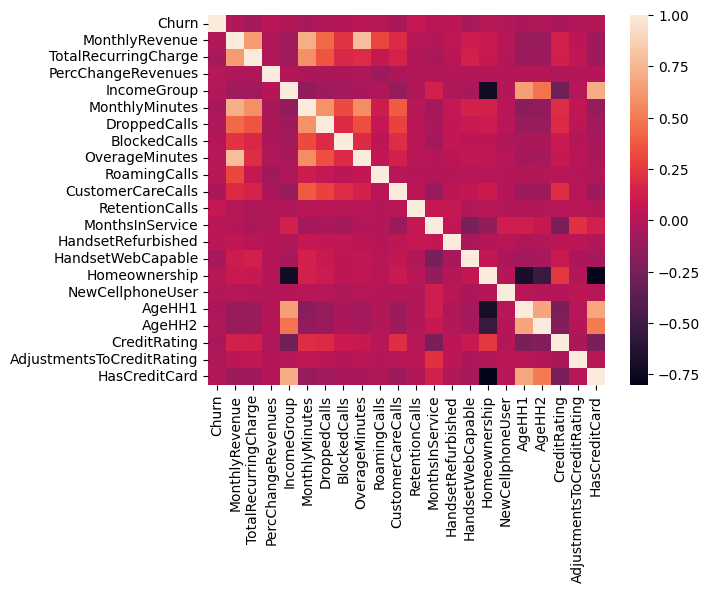

In [33]:
objects = []
origin_train.dtypes
for idx in range(len(origin_train.columns)):
    if origin_train.dtypes[idx] == object:
        objects.append(origin_train.columns[idx])

train, _ = convert_category_into_integer(origin_train, objects)
test, _ = convert_category_into_integer(origin_test, objects)

## 데이터 종류가 object인 칼럼을 카테고리화 하기
train = astype_to_category(train)
test = astype_to_category(test)
drop_columns = ['ActiveSubs', 'HandsetRefurbished', 'HandsetWebCapable', 'ServiceArea', 'ChildrenInHH', 'TruckOwner', 'RVOwner', 'Homeownership', 'BuysViaMailOrder', 'RespondsToMailOffers', 'OptOutMailings', 'NonUSTravel', 'OwnsComputer', 'HasCreditCard', 'NewCellphoneUser', 'NotNewCellphoneUser', 'NonUSTravel', 'MadeCallToRetentionTeam', 'OwnsMotorcycle', 'CreditRating', 'MaritalStatus', 'Occupation', 'PrizmCode']
columns = ['Churn', 'MonthlyRevenue', 'TotalRecurringCharge', 'PercChangeRevenues', 'IncomeGroup',\
           'MonthlyMinutes', 'DroppedCalls', 'BlockedCalls', 'OverageMinutes', 'RoamingCalls',\
           'CustomerCareCalls', 'RetentionCalls', 'MonthsInService', 'HandsetRefurbished', 'HandsetWebCapable',\
           'Homeownership', 'NewCellphoneUser', 'AgeHH1', 'AgeHH2',\
           'CreditRating', 'AdjustmentsToCreditRating', 'HasCreditCard']
# df = train.drop(columns=drop_columns).corr()
df = train.filter(items=columns).corr()
display(sns.heatmap(df, annot=False))
df = pd.DataFrame(df.iloc[1, :].T)
# display(df.sort_values(by='Churn', ascending=False))